<a href="https://colab.research.google.com/github/VesalAhsani/pytorch-GANs/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generative Adversarial Networks - GANs**

## Deep Convolutional Generative Adversarial Network - **DCGAN**

Literally nothing changed in the training loop of DCGAN compared to vanilla GAN:

    Things that changed:
        * Model architecture - using CNNs compared to fully connected networks
        * We're now using CelebA dataset loaded via utils.get_celeba_data_loader (MNIST would work, it's just too easy)
        * Logging parameters and number of epochs (as we have bigger images)


### DCGAN implementation
    Note1:
        Many implementations out there, including PyTorch's official, did certain deviations from the original arch,
        without clearly explaining why they did it. PyTorch for intance uses 512 channels initially instead of 1024.
    Note2:
        Small modification I did compared to the original paper -- I used kernel size = 4 as I can't get 64x64
        output spatial dimension with 5 no matter the padding setting. I noticed others did the same thing.
        Also I'm not doing 0-centered normal weight initialization -- it actually gives far worse results.
        Batch normalization, in general, reduced the need for smart initialization but it obviously still matters.


In [1]:
import os
import shutil
import argparse
import re
import time
import enum
import zipfile


import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


import torch
from torch import nn
from torch.optim import Adam
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

In [2]:
BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries') 
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data') 
DEBUG_IMAGERY_PATH = os.path.join(DATA_DIR_PATH, 'debug_imagery')


# Make sure these exist
os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(CHECKPOINTS_PATH, exist_ok=True)
os.makedirs(DATA_DIR_PATH, exist_ok=True)
os.makedirs(DEBUG_IMAGERY_PATH, exist_ok=True)


LATENT_SPACE_DIM = 100  # input random vector size to generator network
MNIST_IMG_SIZE = 28
MNIST_NUM_CLASSES = 10
batch_size = 128


class GANType(enum.Enum):
    VANILLA = 0,
    CGAN = 1,
    DCGAN = 2

**Note:** There were debates to whether `BatchNorm` should go before or after the activation function. 

>In my experiments it did not matter. `Goodfellow` also had a talk where he mentioned that it should not matter.

In [3]:
def dcgan_upsample_block(in_channels, out_channels, normalize=True, activation=None):
    # Bias set to True gives unnatural color casts
    layers = [nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1, bias=False)]

    if normalize:
        layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.ReLU() if activation is None else activation)
    return layers


class ConvolutionalGenerativeNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Constants as defined in the DCGAN paper
        num_channels_per_layer = [1024, 512, 256, 128, 3]
        self.init_volume_shape = (num_channels_per_layer[0], 4, 4)

        # Both with and without bias gave similar results
        self.linear = nn.Linear(LATENT_SPACE_DIM, num_channels_per_layer[0] * np.prod(self.init_volume_shape[1:]))

        self.net = nn.Sequential(
            *dcgan_upsample_block(num_channels_per_layer[0], num_channels_per_layer[1]),
            *dcgan_upsample_block(num_channels_per_layer[1], num_channels_per_layer[2]),
            *dcgan_upsample_block(num_channels_per_layer[2], num_channels_per_layer[3]),
            *dcgan_upsample_block(num_channels_per_layer[3], num_channels_per_layer[4], normalize=False, activation=nn.Tanh())
        )

    def forward(self, latent_vector_batch):
        latent_vector_batch_projected = self.linear(latent_vector_batch)
        latent_vector_batch_projected_reshaped = latent_vector_batch_projected.view(latent_vector_batch_projected.shape[0], *self.init_volume_shape)

        return self.net(latent_vector_batch_projected_reshaped)


def dcgan_downsample_block(in_channels, out_channels, normalize=True, activation=None, padding=1):
    layers = [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=padding, bias=False)]
    if normalize:
        layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2) if activation is None else activation)
    return layers


class ConvolutionalDiscriminativeNet(nn.Module):
    def __init__(self):
        super().__init__()

        num_channels_per_layer = [3, 128, 256, 512, 1024, 1]

        # Since the last volume has a shape = 1024x4x4, we can do 1 more block and since it has a 4x4 kernels it will
        # collapse the spatial dimension into 1x1 and putting channel number to 1 and padding to 0 we get a scalar value
        # that we can pass into Sigmoid - effectively simulating a fully connected layer.
        self.net = nn.Sequential(
            *dcgan_downsample_block(num_channels_per_layer[0], num_channels_per_layer[1], normalize=False),
            *dcgan_downsample_block(num_channels_per_layer[1], num_channels_per_layer[2]),
            *dcgan_downsample_block(num_channels_per_layer[2], num_channels_per_layer[3]),
            *dcgan_downsample_block(num_channels_per_layer[3], num_channels_per_layer[4]),
            *dcgan_downsample_block(num_channels_per_layer[4], num_channels_per_layer[5], normalize=False, activation=nn.Sigmoid(), padding=0),
        )

    def forward(self, img_batch):
        return self.net(img_batch)

## I tried it and it didn't give good results
# Batch normalization in general reduces the need for smart initialization - that's one of it's main advantages.
def weights_init_normal(m):
    classname = m.__class__.__name__
    print(classname)
    if classname.find("Conv2d") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        # It wouldn't make sense to make this 0-centered normal distribution as it would clamp the outputs to 0
        # that's why it's 1-centered normal distribution with std dev of 0.02 as specified in the paper
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [4]:
def load_image(img_path, target_shape=None):
    if not os.path.exists(img_path):
        raise Exception(f'Path does not exist: {img_path}')
    img = cv.imread(img_path)[:, :, ::-1]  # [:, :, ::-1] converts BGR (opencv format...) into RGB

    if target_shape is not None:  # resize section
        if isinstance(target_shape, int) and target_shape != -1:  # scalar -> implicitly setting the width
            current_height, current_width = img.shape[:2]
            new_width = target_shape
            new_height = int(current_height * (new_width / current_width))
            img = cv.resize(img, (new_width, new_height), interpolation=cv.INTER_CUBIC)
        else:  # set both dimensions to target shape
            img = cv.resize(img, (target_shape[1], target_shape[0]), interpolation=cv.INTER_CUBIC)

    img = img.astype(np.float32)  # convert from uint8 to float32
    img /= 255.0  # [0, 1] range
    return img


def save_and_maybe_display_image(dump_dir, dump_img, out_res=(256, 256), should_display=False):
    assert isinstance(dump_img, np.ndarray), f'Expected numpy array got {type(dump_img)}.'

    # step1: get next valid image name
    dump_img_name = get_available_file_name(dump_dir)

    # step2: convert to uint8 format
    if dump_img.dtype != np.uint8:
        dump_img = (dump_img*255).astype(np.uint8)

    # step3: write image to the file system
    cv.imwrite(os.path.join(dump_dir, dump_img_name), cv.resize(dump_img[:, :, ::-1], out_res, interpolation=cv.INTER_NEAREST))

    # step4: maybe display part of the function
    if should_display:
        plt.imshow(dump_img)
        plt.show()


def get_available_file_name(input_dir):
    def valid_frame_name(str):
        pattern = re.compile(r'[0-9]{6}\.jpg')  # regex, examples it covers: 000000.jpg or 923492.jpg, etc.
        return re.fullmatch(pattern, str) is not None

    valid_frames = list(filter(valid_frame_name, os.listdir(input_dir)))
    if len(valid_frames) > 0:
        # Images are saved in the <xxxxxx>.jpg format we find the biggest such <xxxxxx> number and increment by 1
        last_img_name = sorted(valid_frames)[-1]
        new_prefix = int(last_img_name.split('.')[0]) + 1  # increment by 1
        return f'{str(new_prefix).zfill(6)}.jpg'
    else:
        return '000000.jpg'


def get_available_binary_name(gan_type_enum=GANType.CGAN):
    def valid_binary_name(binary_name):
        pattern = re.compile(rf'{gan_type_enum.name}_[0-9]{{6}}\.pth')
        return re.fullmatch(pattern, binary_name) is not None

    prefix = gan_type_enum.name
    valid_binary_names = list(filter(valid_binary_name, os.listdir(BINARIES_PATH)))
    if len(valid_binary_names) > 0:
        last_binary_name = sorted(valid_binary_names)[-1]
        new_suffix = int(last_binary_name.split('.')[0][-6:]) + 1  # increment by 1
        return f'{prefix}_{str(new_suffix).zfill(6)}.pth'
    else:
        return f'{prefix}_000000.pth'


def get_gan_data_transform():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((.5,), (.5,))
    ])
    return transform


def get_mnist_dataset():
    # This will download the MNIST the first time it is called
    return datasets.MNIST(root=DATA_DIR_PATH, train=True, download=True, transform=get_gan_data_transform())


def get_mnist_data_loader(batch_size):
    mnist_dataset = get_mnist_dataset()
    mnist_data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return mnist_data_loader


def download_and_prepare_celeba(celeba_path):
    celeba_url = r'https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip'

    # Step1: Download the resource to local filesystem
    print('*' * 50)
    print(f'Downloading {celeba_url}.')
    print('This may take a while the first time, the zip file has 240 MBs.')
    print('*' * 50)

    resource_tmp_path = celeba_path + '.zip'
    torch.hub.download_url_to_file(celeba_url, resource_tmp_path)

    # Step2: Unzip the resource
    print(f'Started unzipping...')
    with zipfile.ZipFile(resource_tmp_path) as zf:
        os.makedirs(celeba_path, exist_ok=True)
        zf.extractall(path=celeba_path)
    print(f'Unzipping to: {celeba_path} finished.')

    # Step3: Remove the temporary resource file
    os.remove(resource_tmp_path)
    print(f'Removing tmp file {resource_tmp_path}.')

    # Step4: Prepare the dataset into a suitable format for PyTorch's ImageFolder
    print(f'Preparing the CelebA dataset.')
    shutil.rmtree(os.path.join(celeba_path, '__MACOSX'))
    dst_data_directory = os.path.join(celeba_path, 'processed_celeba_small')
    os.remove(os.path.join(dst_data_directory, '.DS_Store'))
    data_directory1 = os.path.join(dst_data_directory, 'celeba')
    data_directory2 = os.path.join(data_directory1, 'New Folder With Items')
    for element in os.listdir(data_directory1):
        if os.path.isfile(os.path.join(data_directory1, element)) and element.endswith('.jpg'):
            shutil.move(os.path.join(data_directory1, element), os.path.join(dst_data_directory, element))

    for element in os.listdir(data_directory2):
        if os.path.isfile(os.path.join(data_directory2, element)) and element.endswith('.jpg'):
            shutil.move(os.path.join(data_directory2, element), os.path.join(dst_data_directory, element))

    shutil.rmtree(data_directory1)


def get_celeba_data_loader(batch_size):
    celeba_path = os.path.join(DATA_DIR_PATH, 'CelebA')
    if not os.path.exists(celeba_path):  # We'll have to do this only 1 time.
        download_and_prepare_celeba(celeba_path)

    celeba_dataset = ImageFolder(celeba_path, transform=get_gan_data_transform())
    celeba_data_loader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return celeba_data_loader


def get_gaussian_latent_batch(batch_size, device):
    return torch.randn((batch_size, LATENT_SPACE_DIM), device=device)


def get_gan(device, gan_type_name):
    assert gan_type_name in [gan_type.name for gan_type in GANType], f'Unknown GAN type = {gan_type_name}.'

    if gan_type_name == GANType.VANILLA.name:
        d_net = DiscriminatorNet().train().to(device)
        g_net = GeneratorNet().train().to(device)
    elif gan_type_name == GANType.CGAN.name:
        d_net = ConditionalDiscriminatorNet().train().to(device)
        g_net = ConditionalGeneratorNet().train().to(device)
    elif gan_type_name == GANType.DCGAN.name:
        d_net = ConvolutionalDiscriminativeNet().train().to(device)
        g_net = ConvolutionalGenerativeNet().train().to(device)
    else:
        raise Exception(f'GAN type {gan_type_name} not yet supported.')

    return d_net, g_net


def get_optimizers(d_net, g_net):
    d_opt = Adam(d_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
    g_opt = Adam(g_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
    return d_opt, g_opt


def get_training_state(generator_net, gan_type_name):
    training_state = {
        "state_dict": generator_net.state_dict(),
        "gan_type": gan_type_name
    }
    return training_state


def print_training_info_to_console(training_config):
    print(f'Starting the GAN training.')
    print('*' * 80)
    print(f'Settings: num_epochs={training_config["num_epochs"]}, batch_size={training_config["batch_size"]}')
    print('*' * 80)

    if training_config["console_log_freq"]:
        print(f'Logging to console every {training_config["console_log_freq"]} batches.')
    else:
        print(f'Console logging disabled.')

    print('')

    if training_config["debug_imagery_log_freq"]:
        print(f'Saving intermediate generator images to {training_config["debug_path"]} every {training_config["debug_imagery_log_freq"]} batches.')
    else:
        print(f'Generator intermediate image saving disabled.')

    print('')

    if training_config["checkpoint_freq"]:
        print(f'Saving checkpoint models to {CHECKPOINTS_PATH} every {training_config["checkpoint_freq"]} epochs.')
    else:
        print(f'Checkpoint models saving disabled.')

    print('')

    if training_config['enable_tensorboard']:
        print('Tensorboard enabled. Logging generator and discriminator losses.')
        print('Run "tensorboard --logdir=runs" from your Anaconda (with conda env activated)')
        print('Open http://localhost:6006/ in your browser and you\'re ready to use tensorboard!')
    else:
        print('Tensorboard logging disabled.')
    print('*' * 80)

In [5]:
def train_dcgan(training_config):
    writer = SummaryWriter()  # (tensorboard) writer will output to ./runs/ directory by default
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Prepare CelebA data loader (it will download preprocessed CelebA the first time you run it ~240 MB)
    celeba_data_loader = get_celeba_data_loader(training_config['batch_size'])

    # Fetch convolutional nets (place them on GPU if present) and optimizers which will tweak their weights
    discriminator_net, generator_net = get_gan(device, GANType.DCGAN.name)
    discriminator_opt, generator_opt = get_optimizers(discriminator_net, generator_net)

    # 1s will configure BCELoss into -log(x) whereas 0s will configure it to -log(1-x)
    adversarial_loss = nn.BCELoss()
    real_images_gt = torch.ones((training_config['batch_size'], 1, 1, 1), device=device)
    fake_images_gt = torch.zeros((training_config['batch_size'], 1, 1, 1), device=device)

    # For logging purposes
    ref_batch_size = 25
    ref_noise_batch = get_gaussian_latent_batch(ref_batch_size, device)  # Track G's quality during training
    discriminator_loss_values = []
    generator_loss_values = []
    img_cnt = 0

    ts = time.time()  # start measuring time

    # GAN training loop, 
######## it's always smart to first train the discriminator so as to avoid mode collapse!

    print_training_info_to_console(training_config)
    for epoch in range(training_config['num_epochs']):
        for batch_idx, (real_images, _) in enumerate(celeba_data_loader):

            real_images = real_images.to(device)

           
            # Train discriminator: maximize V = log(D(x)) + log(1-D(G(z))) or equivalently minimize -V
            # Note: D = discriminator, x = real images, G = generator, z = latent Gaussian vectors, G(z) = fake images
          

            # Zero out .grad variables in discriminator network (otherwise we would have corrupt results)
            discriminator_opt.zero_grad()

            # -log(D(x)) <- we minimize this by making D(x)/discriminator_net(real_images) as close to 1 as possible
            real_discriminator_loss = adversarial_loss(discriminator_net(real_images), real_images_gt)

            # G(z) | G == generator_net and z == utils.get_gaussian_latent_batch(batch_size, device)
            fake_images = generator_net(get_gaussian_latent_batch(training_config['batch_size'], device))
            # D(G(z)), we call detach() so that we don't calculate gradients for the generator during backward()
            fake_images_predictions = discriminator_net(fake_images.detach())
            # -log(1 - D(G(z))) <- we minimize this by making D(G(z)) as close to 0 as possible
            fake_discriminator_loss = adversarial_loss(fake_images_predictions, fake_images_gt)

            discriminator_loss = real_discriminator_loss + fake_discriminator_loss
            discriminator_loss.backward()  # this will populate .grad vars in the discriminator net
            discriminator_opt.step()  # perform D weights update according to optimizer's strategy

            # Train generator: minimize V1 = log(1-D(G(z))) or equivalently maximize V2 = log(D(G(z))) (or min of -V2)
            # The original expression (V1) had problems with diminishing gradients for G when D is too good.


            # if you want to cause mode collapse probably the easiest way to do that would be to add "for i in range(n)"
            # here (simply train G more frequent than D), n = 10 worked for me other values will also work.

            # Zero out .grad variables in discriminator network (otherwise we would have corrupt results)
            generator_opt.zero_grad()

            # D(G(z)) (see above for explanations)
            generated_images_predictions = discriminator_net(generator_net(get_gaussian_latent_batch(training_config['batch_size'], device)))
            # By placing real_images_gt here we minimize -log(D(G(z))) which happens when D approaches 1
            # i.e. we're tricking D into thinking that these generated images are real!
            generator_loss = adversarial_loss(generated_images_predictions, real_images_gt)

            generator_loss.backward()  
            generator_opt.step() 

############# Logging and checkpoint creation

            generator_loss_values.append(generator_loss.item())
            discriminator_loss_values.append(discriminator_loss.item())

            if training_config['enable_tensorboard']:
                writer.add_scalars('losses/g-and-d', {'g': generator_loss.item(), 'd': discriminator_loss.item()}, len(celeba_data_loader) * epoch + batch_idx + 1)
                # Save debug imagery to tensorboard also (some redundancy but it may be more beginner-friendly)
                if training_config['debug_imagery_log_freq'] is not None and batch_idx % training_config['debug_imagery_log_freq'] == 0:
                    with torch.no_grad():
                        log_generated_images = generator_net(ref_noise_batch)
                        log_generated_images_resized = nn.Upsample(scale_factor=2, mode='nearest')(log_generated_images)
                        intermediate_imagery_grid = make_grid(log_generated_images_resized, nrow=int(np.sqrt(ref_batch_size)), normalize=True)
                        writer.add_image('intermediate generated imagery', intermediate_imagery_grid, len(celeba_data_loader) * epoch + batch_idx + 1)

            if training_config['console_log_freq'] is not None and batch_idx % training_config['console_log_freq'] == 0:
                print(f'GAN training: time elapsed= {(time.time() - ts):.2f} [s] | epoch={epoch + 1} | batch= [{batch_idx + 1}/{len(celeba_data_loader)}]')

            # Save intermediate generator images (more convenient like this than through tensorboard)
            if training_config['debug_imagery_log_freq'] is not None and batch_idx % training_config['debug_imagery_log_freq'] == 0:
                with torch.no_grad():
                    log_generated_images = generator_net(ref_noise_batch)
                    log_generated_images_resized = nn.Upsample(scale_factor=2, mode='nearest')(log_generated_images)
                    save_image(log_generated_images_resized, os.path.join(training_config['debug_path'], f'{str(img_cnt).zfill(6)}.jpg'), nrow=int(np.sqrt(ref_batch_size)), normalize=True)
                    img_cnt += 1

            # Save generator checkpoint
            if training_config['checkpoint_freq'] is not None and (epoch + 1) % training_config['checkpoint_freq'] == 0 and batch_idx == 0:
                ckpt_model_name = f"dcgan_ckpt_epoch_{epoch + 1}_batch_{batch_idx + 1}.pth"
                torch.save(get_training_state(generator_net, GANType.DCGAN.name), os.path.join(CHECKPOINTS_PATH, ckpt_model_name))

    # Save the latest generator in the binaries directory
    torch.save(get_training_state(generator_net, GANType.DCGAN.name), os.path.join(BINARIES_PATH, get_available_binary_name(GANType.DCGAN)))


if __name__ == "__main__":
    
    debug_path = os.path.join(DATA_DIR_PATH, 'debug_imagery')
    os.makedirs(debug_path, exist_ok=True)

    parser = argparse.ArgumentParser()
    parser.add_argument("--num_epochs", type=int, help="height of content and style images", default=20)
    parser.add_argument("--batch_size", type=int, help="height of content and style images", default=128)

    parser.add_argument("--enable_tensorboard", type=bool, help="enable tensorboard logging (D and G loss)", default=True)
    parser.add_argument("--debug_imagery_log_freq", type=int, help="log generator images during training (batch) freq", default=20)
    parser.add_argument("--console_log_freq", type=int, help="log to output console (batch) freq", default=20)
    parser.add_argument("--checkpoint_freq", type=int, help="checkpoint model saving (epoch) freq", default=2)
    parser.add_argument('-f') # for some reason, it should be written here, avoiding systemExit:2 error.
    args = parser.parse_args()

    # Wrapping training configuration into a dictionary
    training_config = dict()
    for arg in vars(args):
        training_config[arg] = getattr(args, arg)
    training_config['debug_path'] = debug_path

    # train GAN model
    train_dcgan(training_config)

**************************************************
This may take a while the first time, the zip file has 240 MBs.
**************************************************


  0%|          | 0.00/236M [00:00<?, ?B/s]

Started unzipping...
Unzipping to: /content/data/CelebA finished.
Removing tmp file /content/data/CelebA.zip.
Preparing the CelebA dataset.
Starting the GAN training.
********************************************************************************
Settings: num_epochs=20, batch_size=128
********************************************************************************
Logging to console every 20 batches.

Saving intermediate generator images to /content/data/debug_imagery every 20 batches.

Saving checkpoint models to /content/models/checkpoints every 2 epochs.

Tensorboard enabled. Logging generator and discriminator losses.
Run "tensorboard --logdir=runs" from your Anaconda (with conda env activated)
Open http://localhost:6006/ in your browser and you're ready to use tensorboard!
********************************************************************************
GAN training: time elapsed= 8.28 [s] | epoch=1 | batch= [1/702]
GAN training: time elapsed= 23.26 [s] | epoch=1 | batch= [21/702

In [7]:
!nvidia-smi

Tue Nov  8 09:53:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    29W /  70W |   3122MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Phew !! It took 3 hours and 20 minutes running on GPU available for Google colab.

Found DCGAN!


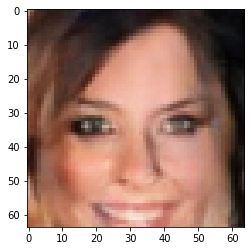

In [38]:
class GenerationMode(enum.Enum):
    SINGLE_IMAGE = 0,
    INTERPOLATION = 1,
    VECTOR_ARITHMETIC = 2


def postprocess_generated_img(generated_img_tensor):
    assert isinstance(generated_img_tensor, torch.Tensor), f'Expected PyTorch tensor but got {type(generated_img_tensor)}.'

    # from 0th to 2nd position (CHW -> HWC)
    generated_img = np.moveaxis(generated_img_tensor.to('cpu').numpy()[0], 0, 2)

    if generated_img.shape[2] == 1:
        generated_img = np.repeat(generated_img,  3, axis=2)

    # Imagery is in the range [-1, 1] (generator has tanh as the output activation) move it into [0, 1] range
    generated_img -= np.min(generated_img)
    generated_img /= np.max(generated_img)

    return generated_img


def generate_from_random_latent_vector(generator, cgan_digit=None):
    with torch.no_grad():
        latent_vector = get_gaussian_latent_batch(1, next(generator.parameters()).device)

        if cgan_digit is None:
            generated_img = postprocess_generated_img(generator(latent_vector))
        else:  # condition and generate the digit specified by cgan_digit
            ref_label = torch.tensor([cgan_digit], dtype=torch.int64)
            ref_label_one_hot_encoding = torch.nn.functional.one_hot(ref_label, MNIST_NUM_CLASSES).type(torch.FloatTensor).to(next(generator.parameters()).device)
            generated_img = postprocess_generated_img(generator(latent_vector, ref_label_one_hot_encoding))

    return generated_img, latent_vector.to('cpu').numpy()[0]


def generate_from_specified_numpy_latent_vector(generator, latent_vector):
    assert isinstance(latent_vector, np.ndarray), f'Expected latent vector to be numpy array but got {type(latent_vector)}.'

    with torch.no_grad():
        latent_vector_tensor = torch.unsqueeze(torch.tensor(latent_vector, device=next(generator.parameters()).device), dim=0)
        return postprocess_generated_img(generator(latent_vector_tensor))


def linear_interpolation(t, p0, p1):
    return p0 + t * (p1 - p0)


def spherical_interpolation(t, p0, p1):
    """ Spherical interpolation (slerp) formula: https://en.wikipedia.org/wiki/Slerp
    Found inspiration here: https://github.com/soumith/ganhacks
    but I didn't get any improvement using it compared to linear interpolation.
    Args:
        t (float): has [0, 1] range
        p0 (numpy array): First n-dimensional vector
        p1 (numpy array): Second n-dimensional vector
    Result:
        Returns spherically interpolated vector.
    """
    if t <= 0:
        return p0
    elif t >= 1:
        return p1
    elif np.allclose(p0, p1):
        return p0

    # Convert p0 and p1 to unit vectors and find the angle between them (omega)
    omega = np.arccos(np.dot(p0 / np.linalg.norm(p0), p1 / np.linalg.norm(p1)))
    sin_omega = np.sin(omega) 
    return np.sin((1.0 - t) * omega) / sin_omega * p0 + np.sin(t * omega) / sin_omega * p1


def display_vector_arithmetic_results(imgs_to_display):
    fig = plt.figure(figsize=(6, 6))
    title_fontsize = 'x-small'
    num_display_imgs = 7
    titles = ['happy women', 'happy woman (avg)', 'neutral women', 'neutral woman (avg)', 'neutral men', 'neutral man (avg)', 'result - happy man']
    ax = np.zeros(num_display_imgs, dtype=object)
    assert len(imgs_to_display) == num_display_imgs, f'Expected {num_display_imgs} got {len(imgs_to_display)} images.'

    gs = fig.add_gridspec(5, 4, left=0.02, right=0.98, wspace=0.05, hspace=0.3)
    ax[0] = fig.add_subplot(gs[0, :3])
    ax[1] = fig.add_subplot(gs[0, 3])
    ax[2] = fig.add_subplot(gs[1, :3])
    ax[3] = fig.add_subplot(gs[1, 3])
    ax[4] = fig.add_subplot(gs[2, :3])
    ax[5] = fig.add_subplot(gs[2, 3])
    ax[6] = fig.add_subplot(gs[3:, 1:3])

    for i in range(num_display_imgs):
        ax[i].imshow(cv.resize(imgs_to_display[i], (0, 0), fx=3, fy=3, interpolation=cv.INTER_NEAREST))
        ax[i].set_title(titles[i], fontsize=title_fontsize)
        ax[i].tick_params(which='both', bottom=False, left=False, labelleft=False, labelbottom=False)

    plt.show()


def generate_new_images(model_name, cgan_digit=None, generation_mode=True, slerp=True, a=None, b=None, should_display=True):
    """ Generate imagery using pre-trained generator
    Args:
        model_name (str): model name you want to use (default lookup location is BINARIES_PATH).
        cgan_digit (int): if specified generate that exact digit.
        generation_mode (enum):  generate a single image from a random vector, interpolate between the 2 chosen latent
         vectors, or perform arithmetic over latent vectors (note: not every mode is supported for every model type)
        slerp (bool): if True use spherical interpolation otherwise use linear interpolation.
        a, b (numpy arrays): latent vectors, if set to None you'll be prompted to choose images you like,
         and use corresponding latent vectors instead.
        should_display (bool): Display the generated images before saving them.
    """

    model_path = os.path.join(BINARIES_PATH, model_name)
    assert os.path.exists(model_path), f'Could not find the model {model_path}. You first need to train your generator.'

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Prepare the correct (vanilla, cGAN, DCGAN, ...) model, load the weights and put the model into evaluation mode
    model_state = torch.load(model_path)
    gan_type = model_state["gan_type"]
    print(f'Found {gan_type}!')
    _, generator = get_gan(device, gan_type)
    generator.load_state_dict(model_state["state_dict"], strict=True)
    generator.eval()

    # Generate a single image, save it and potentially display it
    if generation_mode == GenerationMode.SINGLE_IMAGE:
        generated_imgs_path = os.path.join(DATA_DIR_PATH, 'generated_imagery')
        os.makedirs(generated_imgs_path, exist_ok=True)

        generated_img, _ = generate_from_random_latent_vector(generator, cgan_digit if gan_type == GANType.CGAN.name else None)
        save_and_maybe_display_image(generated_imgs_path, generated_img, should_display=should_display)

    # Pick 2 images you like between which you'd like to interpolate (by typing 'y' into console)
    elif generation_mode == GenerationMode.INTERPOLATION:
        assert gan_type == GANType.VANILLA.name or gan_type ==GANType.DCGAN.name, f'Got {gan_type} but only VANILLA/DCGAN are supported for the interpolation mode.'

        interpolation_name = "spherical" if slerp else "linear"
        interpolation_fn = spherical_interpolation if slerp else linear_interpolation

        grid_interpolated_imgs_path = os.path.join(DATA_DIR_PATH, 'interpolated_imagery')  # combined results dir
        decomposed_interpolated_imgs_path = os.path.join(grid_interpolated_imgs_path, f'tmp_{gan_type}_{interpolation_name}_dump')  # dump separate results
        if os.path.exists(decomposed_interpolated_imgs_path):
            shutil.rmtree(decomposed_interpolated_imgs_path)
        os.makedirs(grid_interpolated_imgs_path, exist_ok=True)
        os.makedirs(decomposed_interpolated_imgs_path, exist_ok=True)

        latent_vector_a, latent_vector_b = [None, None]

        # If a and b were not specified loop until the user picked the 2 images he/she likes.
        found_good_vectors_flag = False
        if a is None or b is None:
            while not found_good_vectors_flag:
                generated_img, latent_vector = generate_from_random_latent_vector(generator)
                plt.imshow(generated_img); plt.title('Do you like this image?'); plt.show()
                user_input = input("Do you like this generated image? [y for yes]:")
                if user_input == 'y':
                    if latent_vector_a is None:
                        latent_vector_a = latent_vector
                        print('Saved the first latent vector.')
                    elif latent_vector_b is None:
                        latent_vector_b = latent_vector
                        print('Saved the second latent vector.')
                        found_good_vectors_flag = True
                else:
                    print('Well lets generate a new one!')
                    continue
        else:
            print('Skipping latent vectors selection section and using cached ones.')
            latent_vector_a, latent_vector_b = [a, b]

        # Cache latent vectors
        if a is None or b is None:
            np.save(os.path.join(grid_interpolated_imgs_path, 'a.npy'), latent_vector_a)
            np.save(os.path.join(grid_interpolated_imgs_path, 'b.npy'), latent_vector_b)

        print(f'Lets do some {interpolation_name} interpolation!')
        interpolation_resolution = 47  # number of images between the vectors a and b
        num_interpolated_imgs = interpolation_resolution + 2  # + 2 so that we include a and b

        generated_imgs = []
        for i in range(num_interpolated_imgs):
            t = i / (num_interpolated_imgs - 1)  # goes from 0. to 1.
            current_latent_vector = interpolation_fn(t, latent_vector_a, latent_vector_b)
            generated_img = generate_from_specified_numpy_latent_vector(generator, current_latent_vector)

            print(f'Generated image [{i+1}/{num_interpolated_imgs}].')
            save_and_maybe_display_image(decomposed_interpolated_imgs_path, generated_img, should_display=should_display)

            # Move from channel last to channel first (CHW->HWC), PyTorch's save_image function expects BCHW format
            generated_imgs.append(torch.tensor(np.moveaxis(generated_img, 2, 0)))

        interpolated_block_img = torch.stack(generated_imgs)
        interpolated_block_img = nn.Upsample(scale_factor=2.5, mode='nearest')(interpolated_block_img)
        save_image(interpolated_block_img, os.path.join(grid_interpolated_imgs_path, get_available_file_name(grid_interpolated_imgs_path)), nrow=int(np.sqrt(num_interpolated_imgs)))

    elif generation_mode == GenerationMode.VECTOR_ARITHMETIC:
        assert gan_type == GANType.DCGAN.name, f'Got {gan_type} but only DCGAN is supported for arithmetic mode.'

        # Generate num_options face images and create a grid image from them
        num_options = 100
        generated_imgs = []
        latent_vectors = []
        padding = 2
        for i in range(num_options):
            generated_img, latent_vector = generate_from_random_latent_vector(generator)
            generated_imgs.append(torch.tensor(np.moveaxis(generated_img, 2, 0)))  # make_grid expects CHW format
            latent_vectors.append(latent_vector)
        stacked_tensor_imgs = torch.stack(generated_imgs)
        final_tensor_img = make_grid(stacked_tensor_imgs, nrow=int(np.sqrt(num_options)), padding=padding)
        display_img = np.moveaxis(final_tensor_img.numpy(), 0, 2)

        # For storing latent vectors
        num_of_vectors_per_category = 3
        happy_woman_latent_vectors = []
        neutral_woman_latent_vectors = []
        neutral_man_latent_vectors = []

        # Make it easy - by clicking on the plot you pick the image.
        def onclick(event):
            if event.dblclick:
                pass
            else:  # single click
                if event.button == 1:  # left click
                    x_coord = event.xdata
                    y_coord = event.ydata
                    column = int(x_coord / (64 + padding))
                    row = int(y_coord / (64 + padding))

                    # Store latent vector corresponding to the image that the user clicked on.
                    if len(happy_woman_latent_vectors) < num_of_vectors_per_category:
                        happy_woman_latent_vectors.append(latent_vectors[10*row + column])
                        print(f'Picked image row={row}, column={column} as {len(happy_woman_latent_vectors)}. happy woman.')
                    elif len(neutral_woman_latent_vectors) < num_of_vectors_per_category:
                        neutral_woman_latent_vectors.append(latent_vectors[10*row + column])
                        print(f'Picked image row={row}, column={column} as {len(neutral_woman_latent_vectors)}. neutral woman.')
                    elif len(neutral_man_latent_vectors) < num_of_vectors_per_category:
                        neutral_man_latent_vectors.append(latent_vectors[10*row + column])
                        print(f'Picked image row={row}, column={column} as {len(neutral_man_latent_vectors)}. neutral man.')
                    else:
                        plt.close()

        plt.figure(figsize=(10, 10))
        plt.imshow(display_img)
        # This is just an example you could also pick 3 neutral woman images with sunglasses, etc.
        plt.title('Click on 3 happy women, 3 neutral women and \n 3 neutral men images (order matters!)')
        cid = plt.gcf().canvas.mpl_connect('button_press_event', onclick)
        plt.show()
        plt.gcf().canvas.mpl_disconnect(cid)
        print('Done choosing images.')

        # Calculate the average latent vector for every category (happy woman, neutral woman, neutral man)
        happy_woman_avg_latent_vector = np.mean(np.array(happy_woman_latent_vectors), axis=0)
        neutral_woman_avg_latent_vector = np.mean(np.array(neutral_woman_latent_vectors), axis=0)
        neutral_man_avg_latent_vector = np.mean(np.array(neutral_man_latent_vectors), axis=0)

        # By subtracting neutral woman from the happy woman we capture the "vector of smiling". Adding that vector
        # to a neutral man we get a happy man's latent vector! 
        happy_man_latent_vector = neutral_man_avg_latent_vector + (happy_woman_avg_latent_vector - neutral_woman_avg_latent_vector)

        # Generate images from these latent vectors
        happy_women_imgs = np.hstack([generate_from_specified_numpy_latent_vector(generator, v) for v in happy_woman_latent_vectors])
        neutral_women_imgs = np.hstack([generate_from_specified_numpy_latent_vector(generator, v) for v in neutral_woman_latent_vectors])
        neutral_men_imgs = np.hstack([generate_from_specified_numpy_latent_vector(generator, v) for v in neutral_man_latent_vectors])

        happy_woman_avg_img = generate_from_specified_numpy_latent_vector(generator, happy_woman_avg_latent_vector)
        neutral_woman_avg_img = generate_from_specified_numpy_latent_vector(generator, neutral_woman_avg_latent_vector)
        neutral_man_avg_img = generate_from_specified_numpy_latent_vector(generator, neutral_man_avg_latent_vector)

        happy_man_img = generate_from_specified_numpy_latent_vector(generator, happy_man_latent_vector)

        display_vector_arithmetic_results([happy_women_imgs, happy_woman_avg_img, neutral_women_imgs, neutral_woman_avg_img, neutral_men_imgs, neutral_man_avg_img, happy_man_img])
    else:
        raise Exception(f'Generation mode not yet supported.')


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_name", type=str, help="Pre-trained generator model name", default=r'DCGAN_000000.pth')
    parser.add_argument("--cgan_digit", type=int, help="Used only for cGAN - generate specified digit", default=3)
    parser.add_argument("--generation_mode", type=bool, help="Pick between 3 generation modes", default=GenerationMode.SINGLE_IMAGE)
    parser.add_argument("--slerp", type=bool, help="Should use spherical interpolation (default No)", default=False)
    parser.add_argument("--should_display", type=bool, help="Display intermediate results", default=True)
    parser.add_argument('-f')
    args = parser.parse_args()

    # The first time you start generation in the interpolation mode it will cache a and b
    # which you'll choose the first time you run the it.
    a_path = os.path.join(DATA_DIR_PATH, 'interpolated_imagery', 'a.npy')
    b_path = os.path.join(DATA_DIR_PATH, 'interpolated_imagery', 'b.npy')
    latent_vector_a = np.load(a_path) if os.path.exists(a_path) else None
    latent_vector_b = np.load(b_path) if os.path.exists(b_path) else None

    generate_new_images(
        args.model_name,
        args.cgan_digit,
        generation_mode=args.generation_mode,
        slerp=args.slerp,
        a=latent_vector_a,
        b=latent_vector_b,
        should_display=args.should_display)

Found DCGAN!
Skipping latent vectors selection section and using cached ones.
Lets do some linear interpolation!
Generated image [1/49].


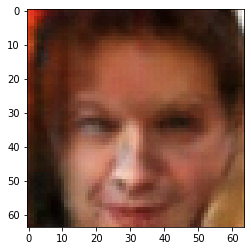

Generated image [2/49].


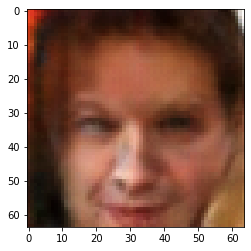

Generated image [3/49].


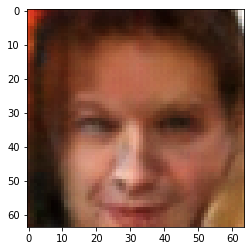

Generated image [4/49].


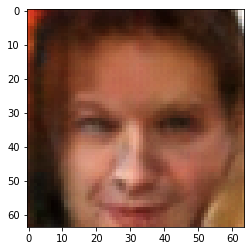

Generated image [5/49].


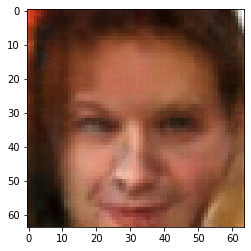

Generated image [6/49].


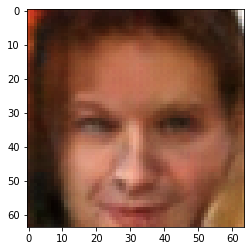

Generated image [7/49].


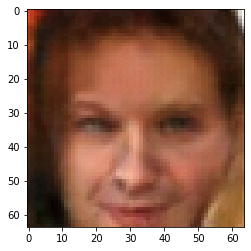

Generated image [8/49].


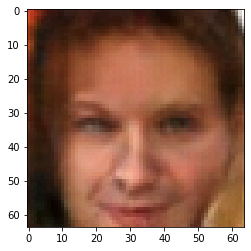

Generated image [9/49].


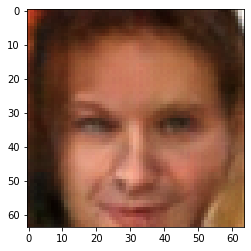

Generated image [10/49].


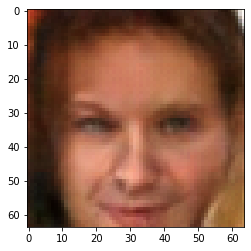

Generated image [11/49].


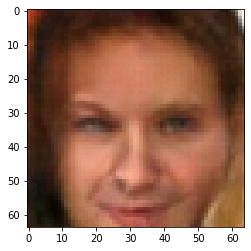

Generated image [12/49].


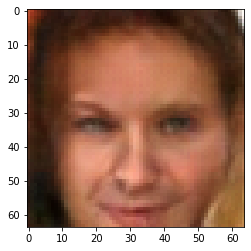

Generated image [13/49].


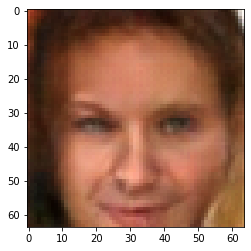

Generated image [14/49].


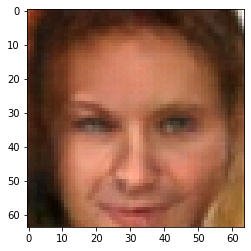

Generated image [15/49].


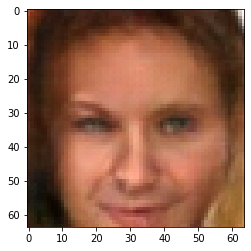

Generated image [16/49].


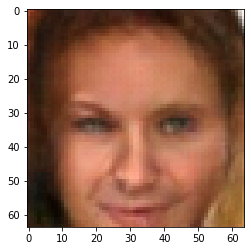

Generated image [17/49].


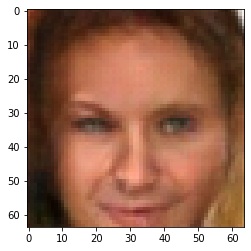

Generated image [18/49].


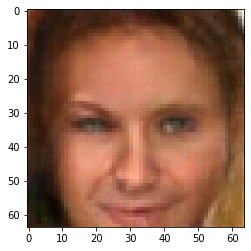

Generated image [19/49].


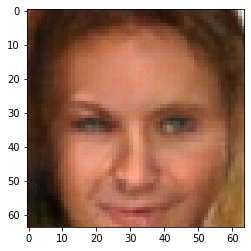

Generated image [20/49].


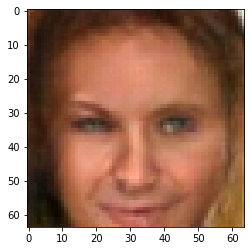

Generated image [21/49].


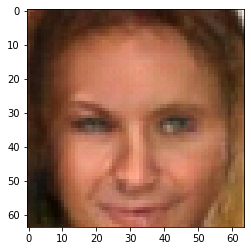

Generated image [22/49].


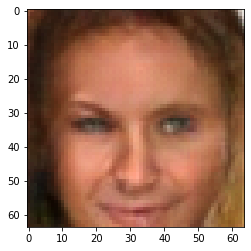

Generated image [23/49].


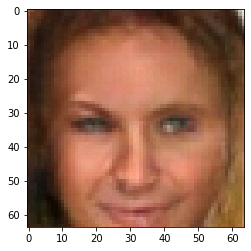

Generated image [24/49].


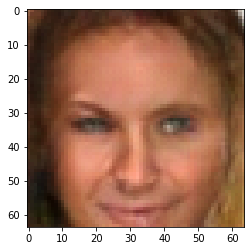

Generated image [25/49].


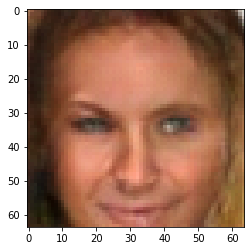

Generated image [26/49].


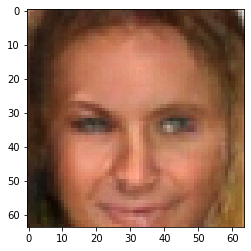

Generated image [27/49].


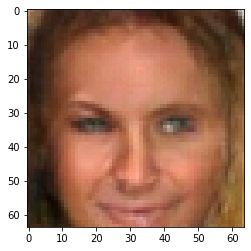

Generated image [28/49].


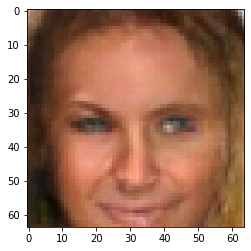

Generated image [29/49].


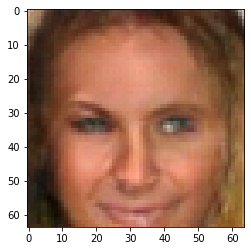

Generated image [30/49].


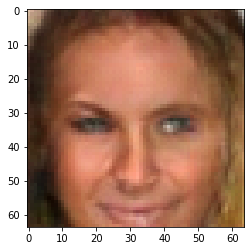

Generated image [31/49].


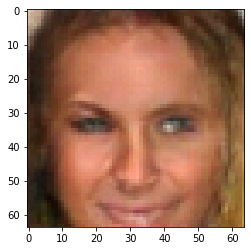

Generated image [32/49].


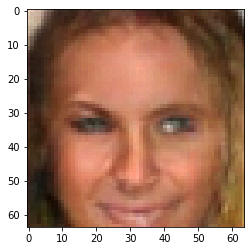

Generated image [33/49].


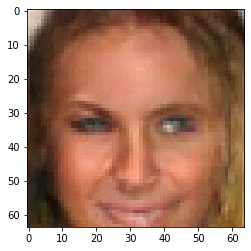

Generated image [34/49].


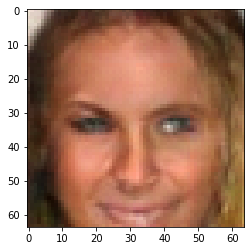

Generated image [35/49].


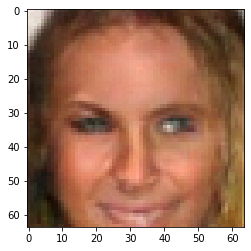

Generated image [36/49].


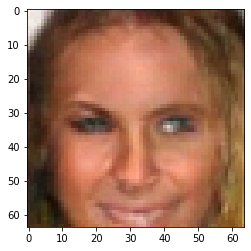

Generated image [37/49].


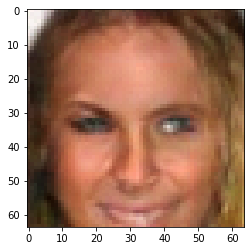

Generated image [38/49].


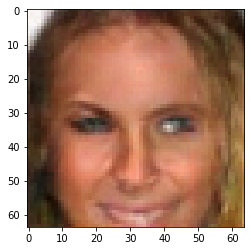

Generated image [39/49].


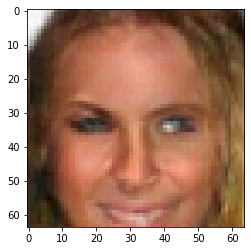

Generated image [40/49].


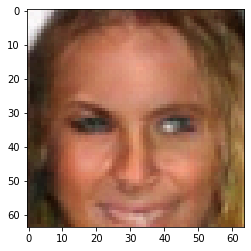

Generated image [41/49].


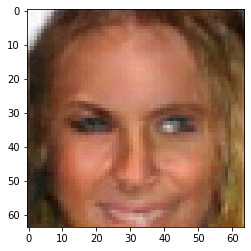

Generated image [42/49].


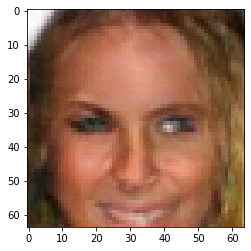

Generated image [43/49].


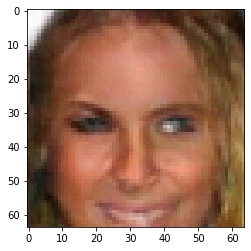

Generated image [44/49].


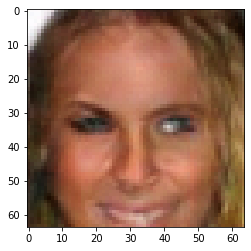

Generated image [45/49].


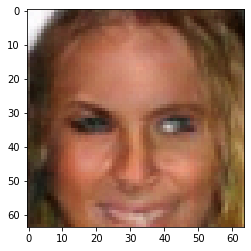

Generated image [46/49].


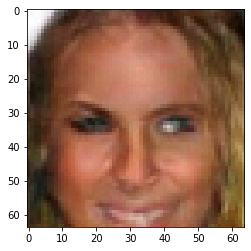

Generated image [47/49].


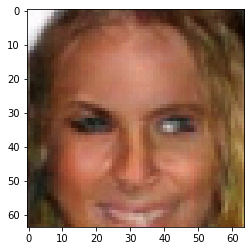

Generated image [48/49].


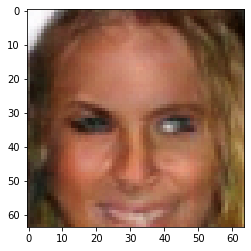

Generated image [49/49].


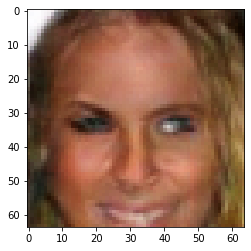

In [14]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_name", type=str, help="Pre-trained generator model name", default=r'DCGAN_000000.pth')
    parser.add_argument("--cgan_digit", type=int, help="Used only for cGAN - generate specified digit", default=3)
    parser.add_argument("--generation_mode", type=bool, help="Pick between 3 generation modes", default=GenerationMode.INTERPOLATION)
    parser.add_argument("--slerp", type=bool, help="Should use spherical interpolation (default No)", default=False)
    parser.add_argument("--should_display", type=bool, help="Display intermediate results", default=True)
    parser.add_argument('-f')
    args = parser.parse_args()

    # The first time you start generation in the interpolation mode it will cache a and b
    # which you'll choose the first time you run the it.
    a_path = os.path.join(DATA_DIR_PATH, 'interpolated_imagery', 'a.npy')
    b_path = os.path.join(DATA_DIR_PATH, 'interpolated_imagery', 'b.npy')
    latent_vector_a = np.load(a_path) if os.path.exists(a_path) else None
    latent_vector_b = np.load(b_path) if os.path.exists(b_path) else None

    generate_new_images(
        args.model_name,
        args.cgan_digit,
        generation_mode=args.generation_mode,
        slerp=args.slerp,
        a=latent_vector_a,
        b=latent_vector_b,
        should_display=args.should_display)

>GenerationMode.VECTOR_ARITHMETIC will give you an interactive matplotlib plot to pick 9 images.



In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_name", type=str, help="Pre-trained generator model name", default=r'DCGAN_000000.pth')
    parser.add_argument("--cgan_digit", type=int, help="Used only for cGAN - generate specified digit", default=3)
    parser.add_argument("--generation_mode", type=bool, help="Pick between 3 generation modes", default=GenerationMode.VECTOR_ARITHMETIC)
    parser.add_argument("--slerp", type=bool, help="Should use spherical interpolation (default No)", default=False)
    parser.add_argument("--should_display", type=bool, help="Display intermediate results", default=True)
    parser.add_argument('-f')
    args = parser.parse_args()

    # The first time you start generation in the interpolation mode it will cache a and b
    # which you'll choose the first time you run the it.
    a_path = os.path.join(DATA_DIR_PATH, 'interpolated_imagery', 'a.npy')
    b_path = os.path.join(DATA_DIR_PATH, 'interpolated_imagery', 'b.npy')
    latent_vector_a = np.load(a_path) if os.path.exists(a_path) else None
    latent_vector_b = np.load(b_path) if os.path.exists(b_path) else None

    generate_new_images(
        args.model_name,
        args.cgan_digit,
        generation_mode=args.generation_mode,
        slerp=args.slerp,
        a=latent_vector_a,
        b=latent_vector_b,
        should_display=args.should_display)

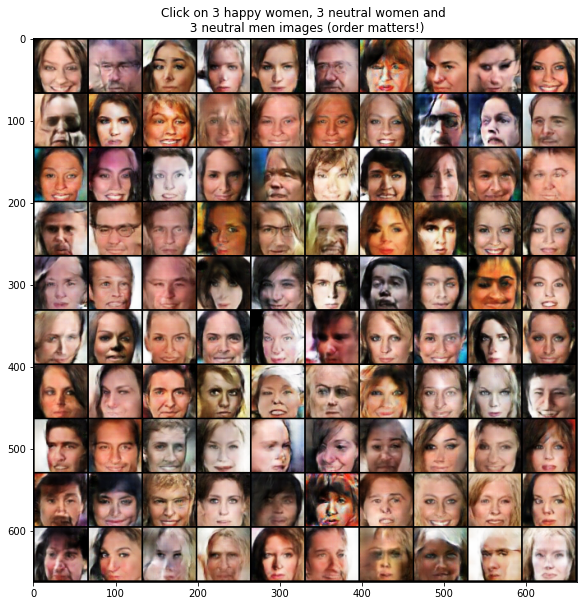